# Model Training
Where I train the model

In [47]:
import torch
from torch import optim
from torch import nn
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


from cnn.models import Model
from data.import_data import load_dataset, get_dataloader

## Device, Loss Function

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.BCELoss()

## Loading Data

In [5]:
# load in TensorDatasets -- these will then be used to populate the dataloaders

train_dataset = load_dataset('data/meta/train.csv', files_to_load=100)
test_dataset = load_dataset('data/meta/test.csv', files_to_load=100)

## Hyperparameters

In [6]:
# define our hyperparameter options
## these will be used for some basic hyperparameter tuning

num_channels_list = [4, 8, 16, 32, 64, 128]
lrs_list = [.001, .0005, .0001]
bses_list = [8, 16, 32, 64, 128]

epochs = 100

## Training

In [59]:
def train(num_channels, learning_rate, batch_size, epochs,
          display=False):
    '''
    Trains a model with the given hyperparameters.

    Parameters
    ----------
    num_channels : int
        The number of channels to use in the model.
    learning_rate : float
        The learning rate to use in the optimizer.
    batch_size : int
        The batch size to use in the dataloaders.
    epochs : int
        The number of epochs to train for.
    display : bool | False
        Whether or not to plot the loss over time and display it.

    Returns
    -------
    model : Model
        The trained model.
    '''

    # get the dataloaders
    train_loader = get_dataloader(train_dataset, batch_size=batch_size)
    test_loader = get_dataloader(test_dataset, batch_size=batch_size)

    # define the model
    model = Model(num_channels=num_channels).to(device)

    # define the optimizer
    opt = optim.Adam(model.parameters(), lr=learning_rate)

    # keep track of the losses - to plot loss over time, as well as to use for early stopping
    train_losses = []
    test_losses = []

    # train the model
    for epoch in range(epochs):

        # set the model to train mode
        model.train()
        train_loss = 0

        # iterate over the training data
        for inputs, targets in train_loader:
            preds = model(inputs)
            
            loss = loss_func(preds, targets)
            train_loss += loss.item()
                    
            opt.zero_grad()
                
            loss.backward()
            opt.step()
        
        train_losses.append(train_loss)

        # set the model to evaluation mode
        model.eval()

        # calculate the test loss
        with torch.no_grad():
            test_loss = 0
            for inputs, targets in test_loader:
                preds = model(inputs)
                test_loss += loss_func(preds, targets).item()
            
            test_losses.append(test_loss)

            print(f'Epoch: {epoch} | Test Loss: {test_loss}')
        
        # early stopping
        # let it train for at least 3 epochs before stopping
        if epoch > 4:
            # look at the last 3 test losses - if all of them are less than the max test loss, stop training
            ## i.e. if the model has not had any improvement in the last 3 epochs, stop training
            if all(val < max(test_losses) for val in list(test_losses[-3:])):
                print('Stopping early...')
                break
        
    # plot the loss over time
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()
    plt.show()
    
    return model

Epoch: 0 | Test Loss: 6.3271284103393555
Epoch: 1 | Test Loss: 6.018956959247589
Epoch: 2 | Test Loss: 6.251150608062744
Epoch: 3 | Test Loss: 6.54877233505249
Epoch: 4 | Test Loss: 9.344192147254944
Epoch: 5 | Test Loss: 6.152493596076965
Epoch: 6 | Test Loss: 6.191611468791962
Epoch: 7 | Test Loss: 8.56125521659851
Stopping early...


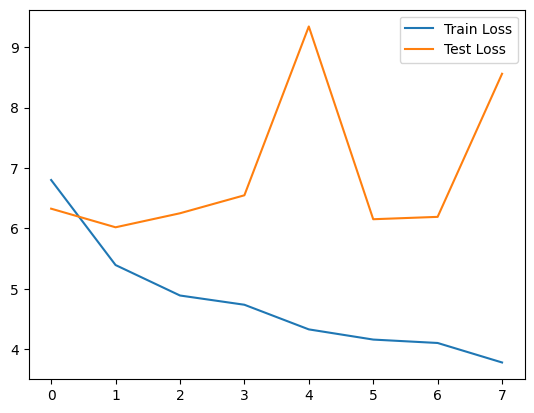

In [62]:
trained_model = train(16, .00001, 128, 20)

## Model Evaluation

In [44]:
def get_optimalROC(probs, targets):
    '''
    Returns the optimal threshold for a model, given the predicted probabilities and the targets.

    Parameters 
    ----------
    probs : torch.tensor
        The predicted probabilities of the model
    targets : torch.tensor
        The true labels of the data

    Returns
    -------
    best_thresh : float
        The optimal threshold for the model
    '''

    probs = probs.cpu().numpy()
    targets = targets.cpu().numpy()

    fpr, tpr, thresholds = metrics.roc_curve(targets, probs)

    J = tpr - fpr

    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    return best_thresh

In [45]:
def eval_model(model, dataset):
    '''
    Given a model and a dataset, evaluate the model on the dataset.add

    Parameters
    ----------
    model : Model
        The model to evaluate
    dataset : TensorDataset
        The dataset to evaluate the model on

    '''

    # get the dataloader, all in one batch
    loader = get_dataloader(dataset, batch_size=100000)

    # set the model to evaluation
    model.eval()

    with torch.no_grad():

        for inputs, targets in loader:
            probs = trained_model(inputs)

            probs = probs[:, 0]
            targets = targets[:, 0]

            thresh = get_optimalROC(probs, targets)
            print(f'Optimal Threshold: {thresh}')
            preds = (probs >= thresh).long()

            probs = probs.cpu().numpy()
            preds = preds.cpu().numpy()
            targets = targets.cpu().numpy()

            roc = metrics.roc_auc_score(targets, probs)

            tn, fp, fn, tp = metrics.confusion_matrix(targets, preds).ravel()

    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    print(f'ROC: {roc}')
    print(f'Accuracy: {accuracy}')
    print(f'Sensitivity: {sens}')
    print(f'Specificity: {spec}')
    print(f'PPV: {ppv}')
    print(f'NPV: {npv}')

    metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(targets, preds)).plot()
    

Optimal Threshold: 0.00018862327851820737
ROC: 0.3831200128527821
Accuracy: 0.3802469135802469
Sensitivity: 0.9929577464788732
Specificity: 0.049429657794676805
PPV: 0.36061381074168797
NPV: 0.9285714285714286


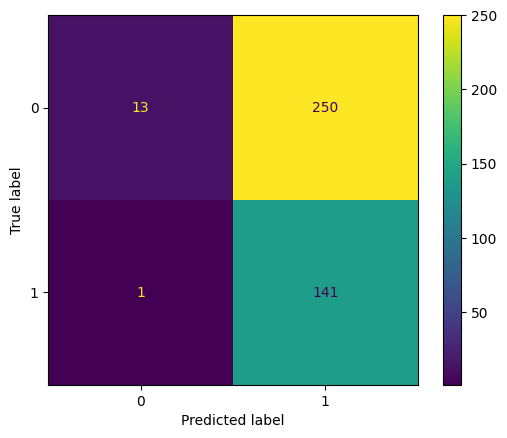

In [63]:
eval_model(trained_model, test_dataset)